# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app", seed = 2)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. A reward of +0.1 is given to an agent if an agent hits the ball over the net. On the other hand, an agent receives a negative reward of -0.01 if an agent lets a ball hit the ground or hits the ball out of bounds.  Thus, the goal of each agent is to keep the ball in play to maximize the total rewards.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# Reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# Number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# Size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# Examine the state space
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.29742813 -1.5
 -0.          0.          7.17024279  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they randomly choose actions at each time step.  A window should pop up that allows you to observe the agents.

In the next section, a modified version of this code will be given such that the agents are able to utilize their experiences to gradually select better actions when interacting with the environment!

In [5]:
#for i in range(1, 6):                                      # play game for 5 episodes
#    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment
#    states = env_info.vector_observations                  # get the current state (for each agent)
#    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#    while True:
#        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#        next_states = env_info.vector_observations         # get next state (for each agent)
#        rewards = env_info.rewards                         # get reward (for each agent)
#        dones = env_info.local_done                        # see if episode finished
#        scores += env_info.rewards                         # update the score (for each agent)
#        states = next_states                               # roll over states to next time step
#        if np.any(dones):                                  # exit loop if episode finished
#            break
#    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
# Load the packages
import matplotlib.pyplot as plt
%matplotlib inline
import random
import time
from collections import deque
import torch
from maddpg import MADDPG_Agent

In [8]:
def train_model(n_episodes = 3000, threshold=0.5, print_every=1):
    """Trains the model and returns the max scores per episode, the cummulative avg scores per 100 episode, and the trained model.

    Params:
        n_episodes (int): number of episodes in the training process. Defaults to 1000.
        threshold (float): score required to solve the environment
        print_every (int): frequency per which to print the performance
    """
    # MADDPG agent
    agent = MADDPG_Agent(state_size, action_size, num_agents, 2)

    scores_tot = [] # store the max scores per episode
    scores_deque = deque(maxlen=100) # store scores in last 100 episodes
    avg_scores_deque = [] # store cummulative avg scores over last 100 episodes


    # It's safe to keep track of elapsed times per print_every
    start_time = time.time()

    for i_episode in range(n_episodes):

        start_time = time.time()                               # reset the start time
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()                                         # reset the noises

        i_episode += 1                                       # increment the episode number

        while True:
            actions = agent.act_all(states)                        # select actions
            env_info = env.step(actions)[brain_name]           # send actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get rewards
            dones = env_info.local_done                        # see if episode has ended
            scores += rewards                                  # update the score (for each agent)

            agent.step(states, actions, rewards, next_states, dones) # store a tuple of experiences and update the agents
            states = next_states                               # proceed to the next states

            if np.any(dones):                                  # exit loop if the episode has ended
                break


        # Compute the max score per episode
        max_score = np.max(scores)
        # Store into each bucket
        scores_tot.append(max_score)
        scores_deque.append(max_score)
        # Compute the average of the cummulative scores in the recent 100 episodes and store into the bucket
        avg_score_deque = np.mean(scores_deque)
        avg_scores_deque.append(avg_score_deque)

        # Display the performance
        if i_episode % print_every ==0:
            elapsed_time = time.time() - start_time # stop to calculate the elapsed time
            print('\rEpisode {}: \tAvg score (over last 100 EPs): {:.3f}\tElapsed time: {:.2f}'.format(i_episode, avg_score_deque, elapsed_time))
            start_time = time.time()

        # See if the environment has been solved
        if avg_score_deque > threshold:
            print("Environment solved in {} EPs!".format(i_episode-100))
            print("Avg score (over last 100 EPs): {}".format(avg_score_deque))

            break

    # Save the trained weights of the agents
    torch.save(agent.maddpg_agents[0].actor_local.state_dict(), 'check_point_agentl_actor.pth')
    torch.save(agent.maddpg_agents[0].critic_local.state_dict(), 'check_point_agentl_critic.pth')
    torch.save(agent.maddpg_agents[1].actor_local.state_dict(), 'check_point_agentr_actor.pth')
    torch.save(agent.maddpg_agents[1].critic_local.state_dict(), 'check_point_agentr_critic.pth')

    return scores_tot, avg_scores_deque, agent

# Train the model, collect the scores
scores_tot, avg_scores_deque, agent = train_model(n_episodes = 5000, threshold=0.5, print_every=10)


Episode 10: 	Avg score (over last 100 EPs): 0.000	Elapsed time: 0.05
Episode 20: 	Avg score (over last 100 EPs): 0.000	Elapsed time: 0.40
Episode 30: 	Avg score (over last 100 EPs): 0.000	Elapsed time: 0.53
Episode 40: 	Avg score (over last 100 EPs): 0.000	Elapsed time: 0.37
Episode 50: 	Avg score (over last 100 EPs): 0.000	Elapsed time: 0.39
Episode 60: 	Avg score (over last 100 EPs): 0.000	Elapsed time: 0.40
Episode 70: 	Avg score (over last 100 EPs): 0.000	Elapsed time: 0.41
Episode 80: 	Avg score (over last 100 EPs): 0.000	Elapsed time: 0.40
Episode 90: 	Avg score (over last 100 EPs): 0.000	Elapsed time: 0.41
Episode 100: 	Avg score (over last 100 EPs): 0.000	Elapsed time: 0.41
Episode 110: 	Avg score (over last 100 EPs): 0.000	Elapsed time: 0.42
Episode 120: 	Avg score (over last 100 EPs): 0.001	Elapsed time: 0.43
Episode 130: 	Avg score (over last 100 EPs): 0.002	Elapsed time: 0.49
Episode 140: 	Avg score (over last 100 EPs): 0.002	Elapsed time: 0.46
Episode 150: 	Avg score (over

In [9]:
# Make sure that you close the environment!
env.close()

### 5. Results

Below we plot the results in the previous section. The first figure shows the history of maximum scores between 2 agents per episode. In the second figure, we plot the cummulative average score over last 100 episodes. Despite the oscillations of scores during the training, the score gradually increased and reached the threshold to solve the environment.

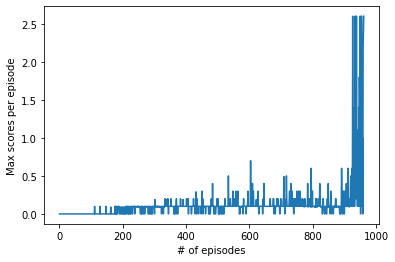

In [9]:
# Plot the max scores per episode
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_tot)+1), scores_tot)
plt.ylabel("Max scores per episode")
plt.xlabel("# of episodes")
plt.show()

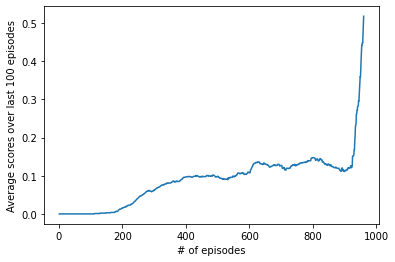

In [11]:
# Plot the cummulative average scores over last 100 episodes wrt number of episodes
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(avg_scores_deque)+1), avg_scores_deque)
plt.ylabel("Average scores over last 100 episodes")
plt.xlabel("# of episodes")
plt.show()